# Imports

In [3]:
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

stopwords = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Let's explore the data

In [4]:
input_data = pd.read_json("data/original/product_data.json")
input_data.sample(5)

,image_url,description
831,https://cdn.theyes.com/images/full/33459d35006...,"Die-cut design, Faux-leather, Double handle, R..."
228,https://cdn.theyes.com/images/full/08e43228597...,\n<p>Be bold. Wear bold stripes.</p>\n<p>If yo...
666,https://cdn.theyes.com/images/full/2712645911e...,"Denim style cotton fabric, Straight fit, Mediu..."
178,https://cdn.theyes.com/images/full/fd6aaa9d700...,Zipper fly Five pocket style Stripe motif The ...
974,https://cdn.theyes.com/images/full/2c224e1d184...,Metal chain Silver color with synthetic pearls...


In [5]:
# How many items have descriptions?
print(f"Items with some description: {sum(input_data.description.apply(len)>0)}")

# How many html tags?
print(f"Items with some html in description: {sum(input_data.description.apply(lambda s: '<' in s and '>' in s))}")


# Tokenize the descriptions
def get_tokens(s):
    s = BeautifulSoup(s, "lxml").text  # Remove html tags
    tokens = word_tokenize(s) # Tokenize
    tokens = [token.lower() for token in tokens if token.isalnum()] # lowercase + remove punctuation
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

def get_tokens_lemmatized(tokens):
    return [
        wordnet_lemmatizer.lemmatize(token)
        for token in tokens            
    ]

input_data["tokens"] = input_data.description.apply(get_tokens)
input_data["tokens_lemmatized"] = input_data.tokens.apply(get_tokens_lemmatized)
input_data[input_data.description.apply(lambda s: '<' in s and '>' in s)].sample(10)

Items with some description: 978
Items with some html in description: 169


,image_url,description,tokens,tokens_lemmatized
228,https://cdn.theyes.com/images/full/08e43228597...,\n<p>Be bold. Wear bold stripes.</p>\n<p>If yo...,"[bold, wear, bold, stripes, love, shirts, want...","[bold, wear, bold, stripe, love, shirt, want, ..."
436,https://cdn.theyes.com/images/full/ac24a03149e...,\n<p>Wearing the Malibu is like wearing a clou...,"[wearing, malibu, like, wearing, cloud, lighte...","[wearing, malibu, like, wearing, cloud, lighte..."
995,https://cdn.theyes.com/images/full/e06af8b9473...,\n<p>The Racer Tank. is longer and narrower th...,"[racer, tank, longer, narrower, body, authenti...","[racer, tank, longer, narrower, body, authenti..."
255,https://cdn.theyes.com/images/full/e2c478e78d8...,The Bailey 44 Aphrodite Dress<span> is a sleev...,"[bailey, 44, aphrodite, dress, sleeveless, fit...","[bailey, 44, aphrodite, dress, sleeveless, fit..."
900,https://cdn.theyes.com/images/full/267a0615b55...,\n<p>Large Lara in Rainbow Confetti</p>\n<ul>\...,"[large, lara, rainbow, confetti, hand, poured,...","[large, lara, rainbow, confetti, hand, poured,..."
828,https://cdn.theyes.com/images/full/23da2a0f3fd...,\n<p> There’s satisfying symmetry in the scoop...,"[satisfying, symmetry, scooped, neck, mirrored...","[satisfying, symmetry, scooped, neck, mirrored..."
395,https://cdn.theyes.com/images/full/9a84f2509c8...,\n<p>CUSTOM EMOJIS WUTTTTTT</p>\n<p>So excited...,"[custom, emojis, wutttttt, excited, launch, mo...","[custom, emojis, wutttttt, excited, launch, mo..."
284,https://cdn.theyes.com/images/full/e0299aa3b1b...,\n<ul>\n<li>High Rise Stove Pipe</li>\n<li>Mad...,"[high, rise, stove, pipe, made, usa, fabric, c...","[high, rise, stove, pipe, made, usa, fabric, c..."
143,https://cdn.theyes.com/images/full/9f7cd467552...,\n<p>Open yourself up to endless possibilities...,"[open, endless, possibilities, cutout, top, pl...","[open, endless, possibility, cutout, top, play..."
99,https://cdn.theyes.com/images/full/f6867b70842...,"\n<p>Based off of our best-selling tee, The Bo...","[based, tee, boxy, dress, cut, easy, body, ang...","[based, tee, boxy, dress, cut, easy, body, ang..."


In [6]:
# Let's check the categories
with open("data/original/product_categories.txt", "r") as f:
    categories = f.read().splitlines()

print(categories)

['TOPS', 'DRESS', 'PANT', 'SKIRT', 'SHORTS', 'LINGERIE', 'OUTERWEAR', 'JUMPSUIT', 'JEWELRY', 'BAG', 'SHOE', 'OTHERS']


['nylon', 'brushed', 'leather', 'two', 'leather', 'handle', 'detachable', 'adjustable', 'leather', 'shoulder', 'strap', 'triangle', 'logo', 'leather', 'logo', 'zipper', 'closure', 'top', 'nylon', 'lining', 'one', 'zipper', 'pocket', 'inside']


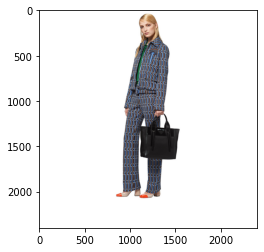

In [7]:
def display_row(image_url, tokens):
    f = requests.get(image_url, stream=True).raw
    img = Image.open(f)
    plt.figure()
    plt.imshow(img)
    print(tokens)
    plt.show()
display_row(input_data.iloc[0].image_url, input_data.iloc[0].tokens_lemmatized)

['calf', 'leather', 'metal', 'lettering', 'logo', 'bow', 'front', 'zipper', 'closure', 'metal', 'chain', 'split', 'ring']


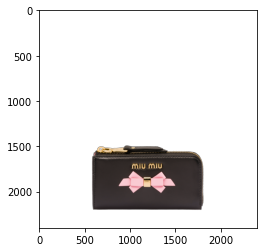

['metal', 'finish']


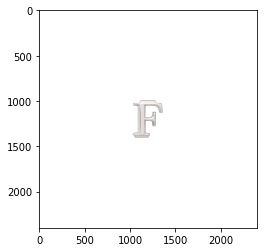

['upper', 'satin', 'thunder', 'design', 'heel', 'colored', 'leather', 'sole', 'metal', 'lettering', 'logo', '105', 'mm', 'heel']


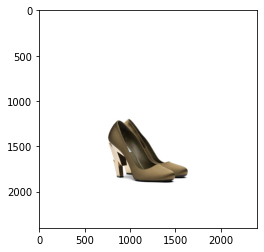

[]


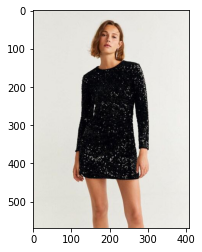

['straight', 'design', 'towel', 'fabric', 'cowl', 'neck', 'sleeveless', 'inner', 'lining']


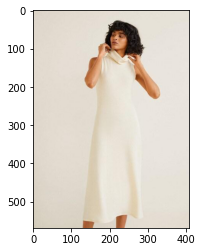

['miu', 'miu', 'twist', 'irresistible', 'new', 'fragrance', 'express', 'joyful', 'essence', 'miu', 'miu', 'vibrant', 'apple', 'blossom', 'blend', 'warm', 'cedar', 'wood', 'pink', 'amber', 'sensual', 'surprising', 'scent', 'top', 'note', 'apple', 'blossom', 'heart', 'note', 'pink', 'musk', 'accord', 'base', 'note', 'tonka', 'bean', 'cedar', 'wood']


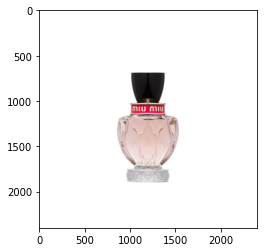

['added', 'pleat', 'sleeve', 'classic', 'sweatshirt', 'body', 'elevated', 'feel', 'wear', 'back', 'anything', 'sweatpants', 'jean', 'skirt', '100', 'cotton', 'model', 'wearing', 'size', '1', 'size', '1', 'length', '23', 'sleeve', 'length', '24', 'machine', 'wash', 'cold', 'tumble', 'dry', 'low', 'made']


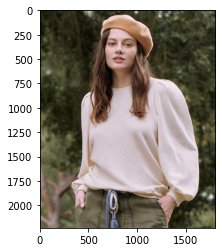

['straight', 'design', 'flowy', 'fabric', 'contrasting', 'decorative', 'seam', 'two', 'chest', 'pocket', 'flap', 'short', 'sleeve', 'concealed', 'button', 'fastening', 'loop', 'waist', 'bow', 'waist']


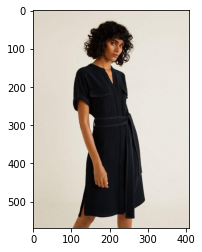

['calf', 'leather', 'saffiano', 'leather', 'handle', 'detachable', 'adjustable', 'saffiano', 'leather', 'shoulder', 'strap', 'enamel', 'triangle', 'logo', 'front', 'zipper', 'pocket', 'drawstring', 'closure', 'top', 'leather', 'lace', 'prada', 'logo', 'nylon', 'lining', 'tag', 'logo', 'inside']


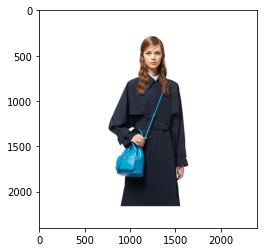

['calf', 'leather', 'detachable', 'adjustable', 'leather', 'shoulder', 'strap', 'detachable', 'adjustable', 'multicolored', 'fabric', 'shoulder', 'strap', 'snap', 'closure', 'two', 'inside', 'pocket', 'including', 'one', 'zipper', 'closure', 'metal', 'logo']


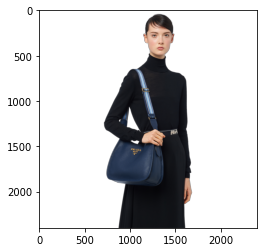

In [8]:
for _, row in input_data.sample(10).iterrows():
    display_row(row.image_url, row.tokens_lemmatized)

Number of rows found: 22
['bow', 'detailing', 'long', 'sleeve', 'make', 'lido', 'dress', 'perfect', 'holiday', 'season', 'featuring', 'scoop', 'neckline', 'cutout', 'detail', 'designed', 'compliment', 'figure', 'flatters', 'waist', 'pair', 'britt', 'bag', 'complete', 'look']


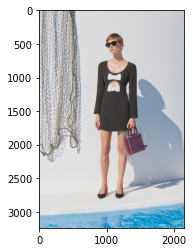

['louise', 'dress', 'one', 'shoulder', 'dress', 'green', 'eyelet', 'fabric', 'one', 'side', 'entire', 'seam', 'featuring', 'functional', 'covered', 'button', 'closure', 'followed', 'side', 'slit', 'keyhole', 'back', 'perfect', 'touch', 'romantic', 'dress', 'lia', 'belt', 'sold', 'separate', 'piece', 'detail', '100', 'cotton', 'made', 'los', 'angeles', 'model', 'wear', 'size', 'small']


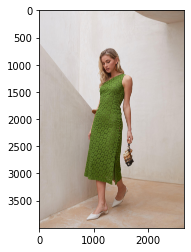

['long', 'button', 'dress', 'concealed', 'button', 'placket', 'buttoned', 'flap', 'pocket', 'chest', 'self', 'belt', 'waist', 'cotton', 'silk', 'blend', 'fabric', 'fine', 'ribbing', 'create', 'shimmery', 'look', 'mother', 'pearl', 'shell', 'button', '10fc5081', 'tab', 'recommend', 'taking', 'regular', 'size', 'model', 'wearing', 'size', '2', 'made', 'italy', '52', 'silk', '48', 'cotton']


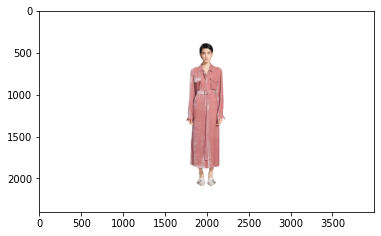

['short', 'sleeve', 'cotton', 'dress', 'forest', 'green', 'eco', 'linen', 'v', 'neck', 'side', 'seam', 'pocket', 'button', 'closure', 'tea', 'length', 'hem', 'tonal', 'stitching', 'interior', 'strap', 'fasten', 'button', 'collar', 'create', 'gathered', 'sleeve', 'please', 'note', 'style', 'run', 'recommend', 'ordering', 'size', 'detail', 'standard', 'u', '55', 'linen', '43', 'viscose', '2', 'elastane']


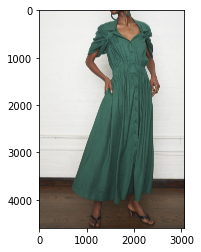

['classic', 'aphrodite', 'get', 'update', 'hammered', 'gold', 'oblong', 'ring', 'neckline', 'floor', 'length', 'halter', 'dress', 'cut', 'out', 'along', 'waist', 'detail', '100', 'polyester', 'made', 'los', 'angeles', 'model', 'wear', 'size', 'small']


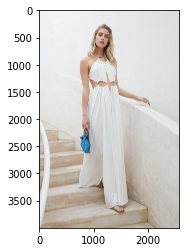

In [9]:
def display_rows_containing_token(input_data, token="", n=None):
    if token:
        filtered_data = input_data[input_data.tokens_lemmatized.apply(lambda tokens: token in tokens)]
    else:
        filtered_data = input_data
    print(f"Number of rows found: {len(filtered_data)}")

    if n is not None:
        filtered_data = filtered_data.sample(n)

    for _, row in filtered_data.iterrows():
        display_row(row.image_url, row.tokens_lemmatized)

display_rows_containing_token(input_data, "dress", n=5)


# Create a labelled dataset

- I'm going to randomly select 50 images and label them so that I have some reference which maps descriptions and images to categories
- Ideally I would have a separate validation and test set separate but given that there are 12 classes, I would need approx 30 images per class per set (magic number based on CLT) ~ 720 images and that's not considering class imbalances

In [10]:
training_data, test_data = train_test_split(input_data, test_size=50, random_state=42)
training_data.shape, test_data.shape

((950, 4), (50, 4))

In [11]:
test_labels = [
    "TOPS",
    "TOPS",
    "OTHERS",
    "OTHERS",
    "SKIRT",
    "BAG",
    "JEWELRY",
    "BAG",
    "PANT",
    "BAG",
    "SKIRT",
    "DRESS",
    "TOPS",
    "SHOE",
    "BAG",
    "OTHERS",
    "TOPS",
    "OTHERS",
    "DRESS",
    "BAG",
    "OUTERWEAR",
    "TOPS",
    "DRESS",
    "OUTERWEAR",
    "BAG",
    "OUTERWEAR",
    "LINGERIE",
    "TOPS",
    "TOPS",
    "OUTERWEAR",
    "OTHERS",
    "SHOE",
    "JUMPER",
    "OTHERS",
    "SHOE",
    "PANT",
    "LINGERIE",
    "LINGERIE",
    "PANT",
    "BAG",
    "HAT",
    "JEWELRY",
    "BAG",
    "JEWELRY",
    "JEWELRY",
    "TOPS",
    "OUTERWEAR",
    "SKIRT",
    "JEWELRY",
    "BAG",
]
print(len(test_labels))
# display_rows_containing_token(test_data.iloc[40:50])

Counter(test_labels)

50


Counter({'BAG': 9,
         'DRESS': 3,
         'HAT': 1,
         'JEWELRY': 5,
         'JUMPER': 1,
         'LINGERIE': 3,
         'OTHERS': 6,
         'OUTERWEAR': 5,
         'PANT': 3,
         'SHOE': 3,
         'SKIRT': 3,
         'TOPS': 8})

# Training
Our goal here is to find important attributes in the training dataset. An attribute here is interesting unigram and bigrams in the description (n=50). We will train an image model which takes as input the image and outputs a bunch of binary values on whether the attributes are present in the image or not.
We can combine d50 vector from the output of the image model and also by string matching the description (max) to get the final attribute list.
This is a rudimentary approach which maps items to a taxonomy of attributes (currently a flat taxonomy).
Once we map each item to the taxonomy, the next step is to use heuristics to map attributes to classes. For the sake of this exercise I'll train a simple tree model on the labelled data set.


In [12]:
all_unigrams = [
    token
    for tokens in training_data.tokens_lemmatized
    for token in tokens
]
print("Most common unigrams")
print(Counter(all_unigrams).most_common(10))


all_bigrams = [
    bigram
    for tokens in training_data.tokens_lemmatized
    if tokens
    for bigram in ngrams(tokens, 2)
    
]
print("Most common bigrams")
print(Counter(all_bigrams).most_common(10))

Most common unigrams
[('fabric', 403), ('design', 362), ('leather', 343), ('sleeve', 292), ('button', 270), ('pocket', 262), ('fastening', 254), ('cotton', 242), ('metal', 222), ('logo', 216)]
Most common bigrams
[(('button', 'fastening'), 155), (('short', 'sleeve'), 108), (('long', 'sleeve'), 107), (('fastening', 'front'), 80), (('cotton', 'fabric'), 80), (('shoulder', 'strap'), 78), (('straight', 'design'), 77), (('front', 'section'), 75), (('lettering', 'logo'), 75), (('metal', 'lettering'), 66)]


In [13]:
some_possible_attributes = [
    "gold",
    "silver",
    "heel",
    "lace",
    "sheer",
    "karat",
    "one piece",
]


training_corpus = training_data.tokens_lemmatized.apply(lambda tokens: " ".join(tokens))
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50)

x = vectorizer.fit_transform(training_corpus)
important_attributes = set(vectorizer.vocabulary_)-set(some_possible_attributes)
important_attributes = set(some_possible_attributes)|(set(list(important_attributes)[:-len(some_possible_attributes)]))
important_attributes = sorted(important_attributes)

for attr in important_attributes:
    print(attr)

100
adjustable
back
button fastening
closure
cotton
cotton fabric
design
detail
fabric
fastening
fastening front
fit
front
front section
gold
heel
inside
karat
lace
lettering
lining
logo
long
long sleeve
made
metal
model
one
one piece
pocket
print
rounded
section
sheer
short
short sleeve
shoulder
shoulder strap
silver
size
sleeve
straight
straight design
strap
two
waist
wash
zip
zipper


# Train the image to attribute model

In [14]:
# Prepare attribute labels
# We use soft labels because presence of an attribute in text is a strong signal that the item has that attribute. 
# But on the flip side, abscence of an attribute in text is only a weak signal that the item has that attribute because the description can be incomplete.
SOFTNESS = 0.2
def get_attribute_labels(df, softness=SOFTNESS):
    all_tokens = df.tokens_lemmatized
    all_attribute_labels = []
    for tokens in all_tokens:
        unigrams = set(tokens)
        bigrams = set(" ".join(bigram) for bigram in ngrams(tokens, 2)) if tokens else set()
        all_ngrams = unigrams|bigrams
        attribute_labels = [
            attr in all_ngrams
            for attr in important_attributes
        ]
        all_attribute_labels.append(attribute_labels)
    
    return np.array(all_attribute_labels)*(1.0-softness) + softness # Soft labels

training_attribute_labels = get_attribute_labels(training_data)
test_attribute_labels = get_attribute_labels(test_data)

In [15]:
def get_image_inputs(df):
    all_images = []
    for image_url in df.image_url:
        f = requests.get(image_url, stream=True).raw
        img = np.asarray(
            Image
            .open(f)
            .resize((224, 224))
            .convert("RGB")
        )/255.
        img = preprocess_input(img)
        all_images.append(img)

    return np.asarray(all_images)

training_image_inputs = get_image_inputs(training_data)
test_image_inputs = get_image_inputs(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [16]:
# Image to attributes model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x=base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(50, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 50)                64050     
                                                                 
Total params: 2,322,034
Trainable params: 64,050
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.TruePositives()]
)

In [19]:
model.fit(training_image_inputs, training_attribute_labels, batch_size=32, epochs=10, verbose=True, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


27/27 [==============================] - 31s 1s/step - loss: 0.6353 - true_positives: 3023.0000 - val_loss: 0.6118 - val_true_positives: 183.0000
Epoch 2/10
27/27 [==============================] - 26s 983ms/step - loss: 0.6037 - true_positives: 504.0000 - val_loss: 0.6052 - val_true_positives: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 27s 988ms/step - loss: 0.6020 - true_positives: 482.0000 - val_loss: 0.6063 - val_true_positives: 115.0000
Epoch 4/10
27/27 [==============================] - 27s 1s/step - loss: 0.6016 - true_positives: 473.0000 - val_loss: 0.6063 - val_true_positives: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 26s 980ms/step - loss: 0.6015 - true_positives: 704.0000 - val_loss: 0.6040 - val_true_positives: 50.0000
Epoch 6/10
27/27 [==============================] - 27s 992ms/step - loss: 0.6009 - true_positives: 475.0000 - val_loss: 0.6066 - val_true_positives: 3.0000
Epoch 7/10
27/27 [==============================] - 27s 1s/st

# Train the attribute to category model

In [20]:
train_attribute_predictions = model.predict(training_image_inputs)
test_attribute_predictions = model.predict(test_image_inputs)

train_class_input = np.hstack((train_attribute_predictions, training_attribute_labels))
test_class_input = np.hstack((test_attribute_predictions, test_attribute_labels))

In [21]:
category_classifier = RandomForestClassifier(100, )
category_classifier.fit(test_class_input, test_labels, )
test_predicted_labels = category_classifier.predict(test_class_input)
train_predicted_labels = category_classifier.predict(train_class_input)

In [22]:
training_data["category"] = train_predicted_labels
test_data["category"] = test_predicted_labels

all_data = pd.concat([training_data, test_data]).sort_index()

In [23]:
output_df = all_data[["image_url", "description", "category"]]

In [24]:
output_df.to_json("local.json", orient="records", lines=True)